In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import cv2
import time

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
import torchvision.models as models
from tqdm import tqdm_notebook

dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [2]:
# Prepare data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = Dataset(dataset_root, download=True, train=True, transform=transform)
testset = Dataset(dataset_root, download=True, train=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

In [3]:
# Create data loaders

batch_size = 64

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Class: Shirt
Shape: (1, 28, 28)


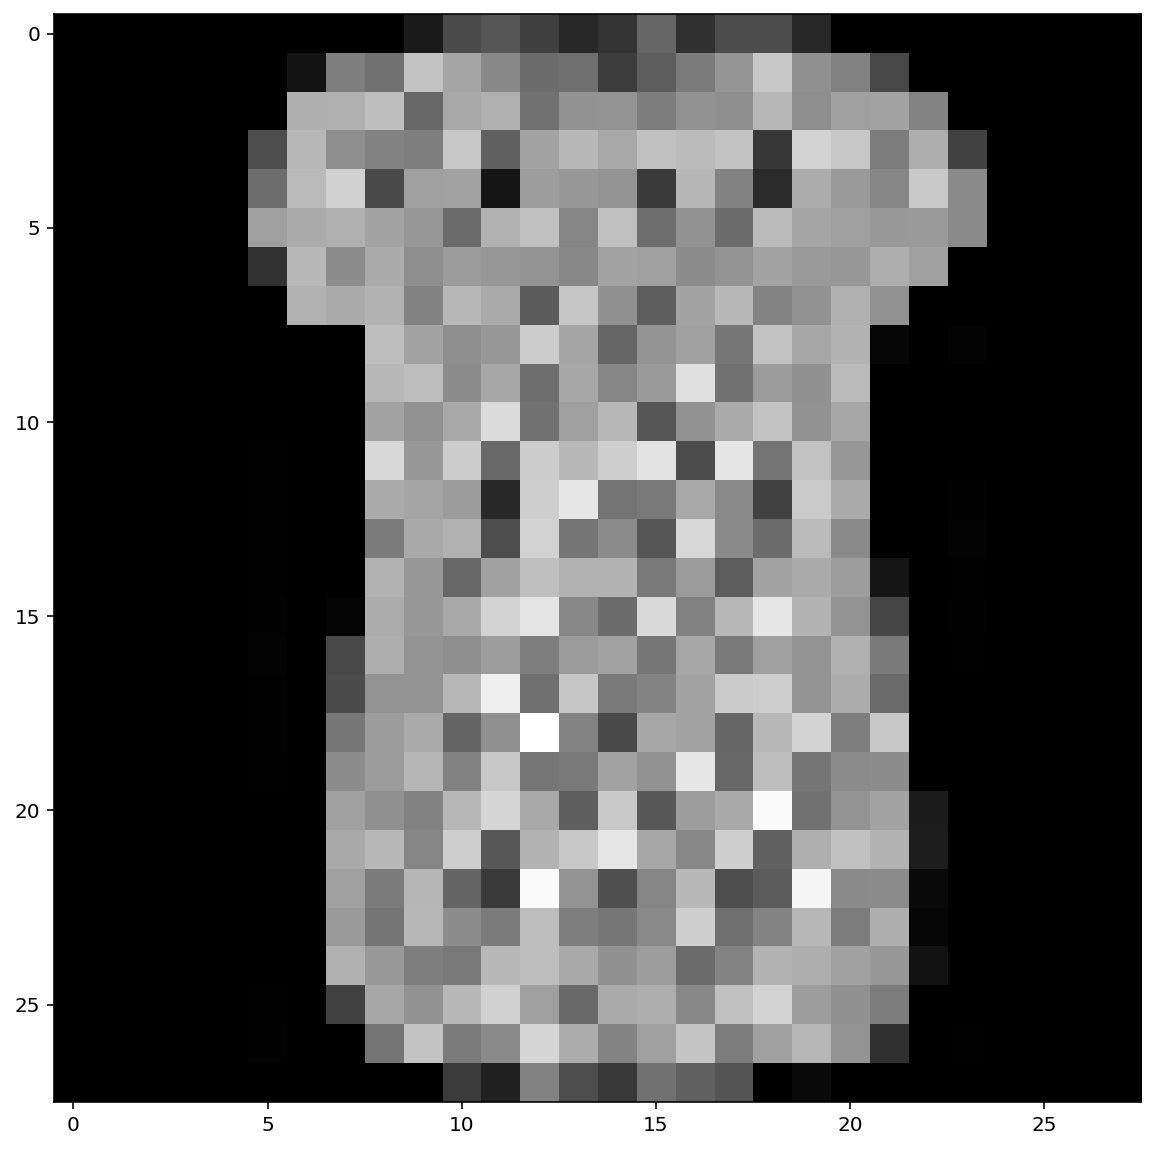

In [4]:
# Show random image shape using iterator

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
plt.imshow(np.squeeze(images[idx]), cmap='gray')
print('Class: ' + str(classes[labels[idx]]))
print('Shape: ' + str(images[idx].shape))

In [5]:
def to_3_channels(one_channel_img):
    return np.vstack((one_channel_img, one_channel_img, one_channel_img))

colorimage = to_3_channels(images[idx])
print(images[idx].shape)
print(colorimage.shape)

(1, 28, 28)
(3, 28, 28)


In [6]:
def to_3_channels_batch(one_channel_img_batch):
    return np.hstack((one_channel_img_batch, one_channel_img_batch,one_channel_img_batch))

In [7]:
def to_3_channels_tensor_batch(one_channel_tensor_batch):
    return torch.squeeze(torch.stack([one_channel_tensor_batch, one_channel_tensor_batch, one_channel_tensor_batch], dim=1))

batch = next(iter(test_loader))
print(batch[0].size())
batch_3_channels = to_3_channels_batch(batch[0])
print(torch.from_numpy(batch_3_channels).size())

torch.Size([64, 1, 28, 28])
torch.Size([64, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

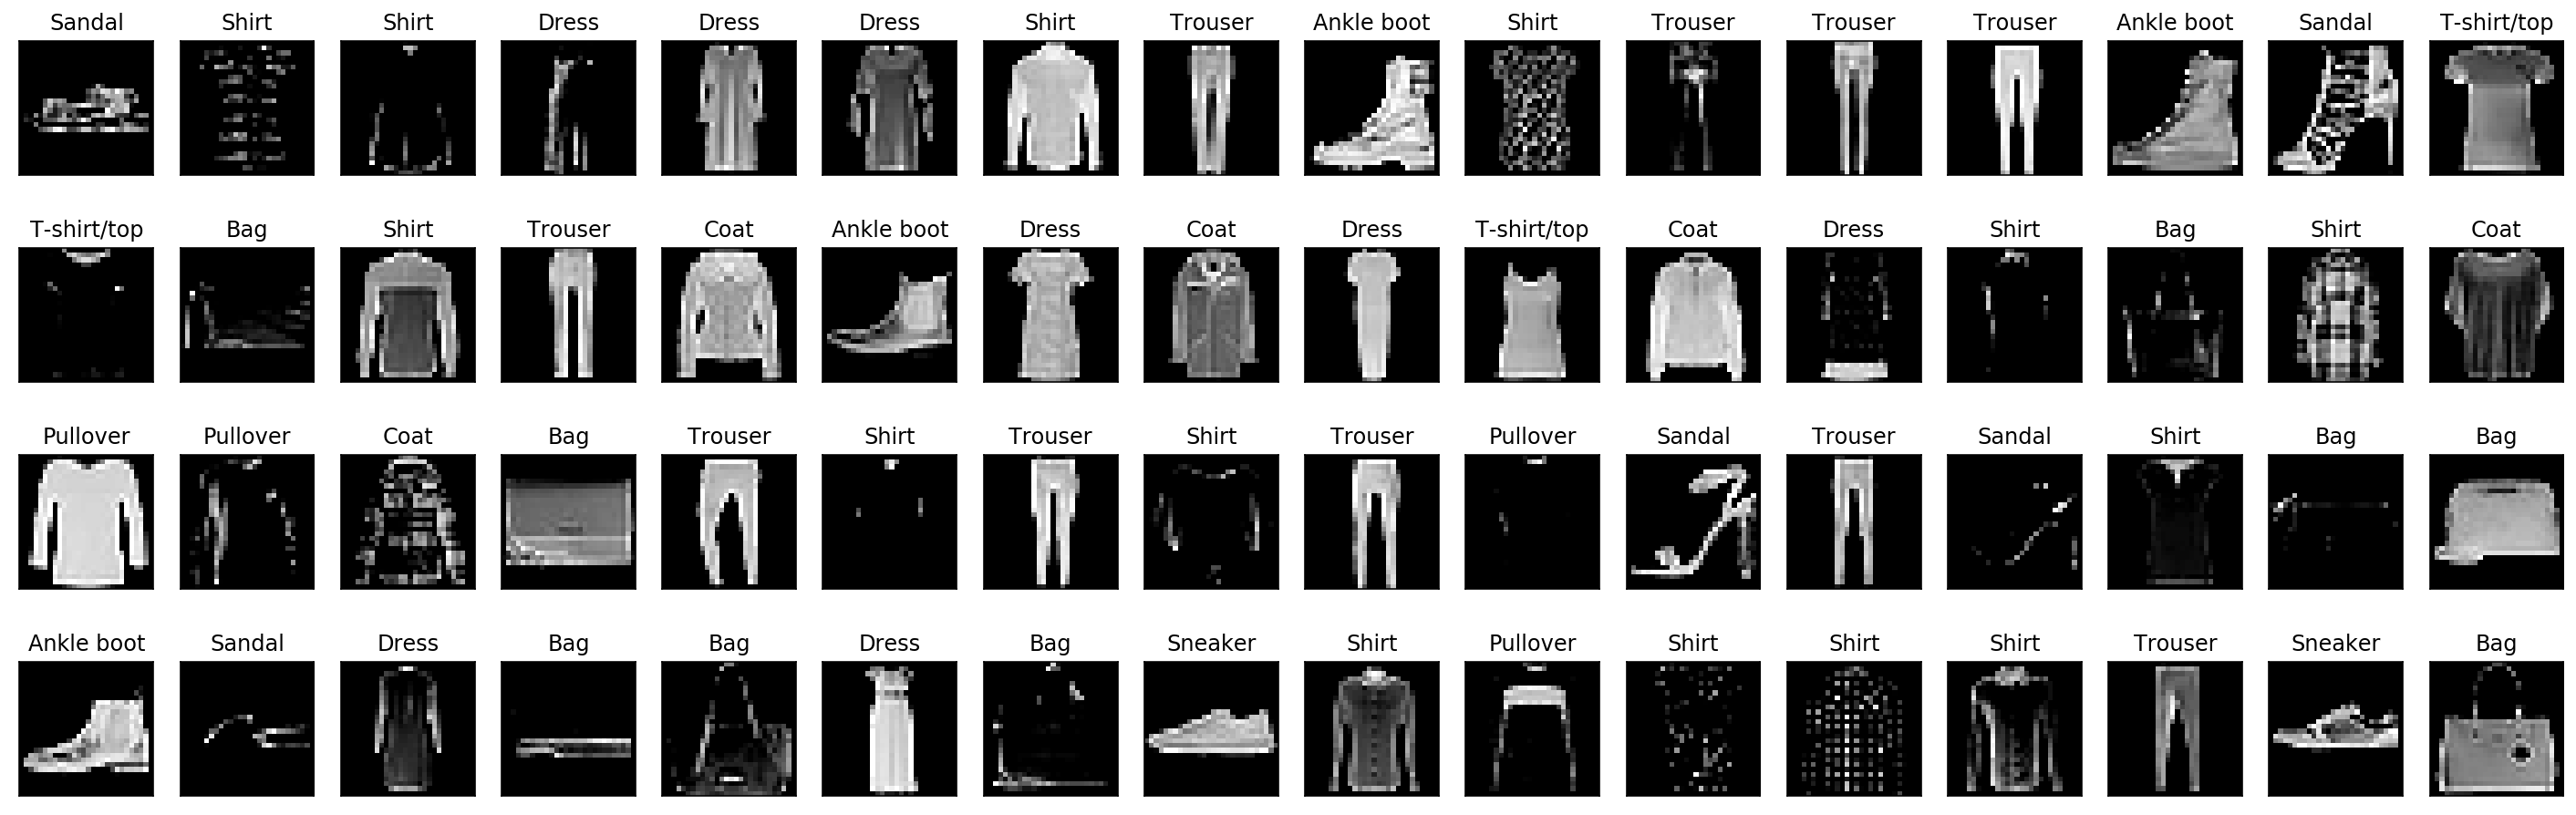

In [8]:
# Show full batch size

fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.moveaxis(to_3_channels(images[idx]), 0, -1))
    ax.set_title(classes[labels[idx]])

In [ ]:
# instantiate and print your pretrained network
net = models.vgg11(pretrained = True)
print(net)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /Users/cenk.bircanoglu/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
  9%|▉         | 46.3M/507M [08:35<52:07, 154kB/s]    

In [ ]:
classifier_childs = list(net.classifier.children())
print(classifier_childs)

In [ ]:
classifier_childs.pop()
print(classifier_childs)

In [ ]:
classifier_childs.append(torch.nn.Linear(4096, num_classes))
print(classifier_childs)

In [ ]:
new_classifier = torch.nn.Sequential(*classifier_childs)
print(new_classifier)

In [ ]:
net.classifier = new_classifier

In [ ]:
# Add batch size using unsqueeze to obtain a single example batch with 3 channels

print(images[idx].shape)
img_pt = torch.from_numpy(to_3_channels(images[idx])).unsqueeze(0)
print(img_pt.shape)

In [ ]:
# Calculate predictions for one sample image
output = net(img_pt)
output.size()

In [ ]:
# Define learning rate, loss function and optimizer

learning_rate = 0.0001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# Calculate accuracy before training
correct = 0
total = 0
net.eval()
for images, labels in tqdm_notebook(test_loader):

    outputs = net(to_3_channels_tensor_batch(images))
    
    _, predicted = torch.max(outputs.data, 1) # output -> value, index

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

accuracy

In [ ]:
# Freeze all layers

for param in net.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze last linear layer

net.classifier[-1].weight.requires_grad = True
net.classifier[-1].bias.requires_grad = True

In [ ]:
# Train loop

print_every = 100

def train(n_epochs):
    net.train()
    loss_over_time = [] # to track the loss as the network trains
    start_time = time.time()
    for epoch in tqdm_notebook(range(n_epochs)):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(tqdm_notebook(train_loader)):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(to_3_channels_tensor_batch(inputs))

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % print_every == print_every//2:    # print every 100 batches (staring from 50)
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, Time: {}'.format(epoch + 1, batch_i+1, avg_loss, str(time.time() - start_time)))
                running_loss = 0.0
                start_time = time.time()


    print('Finished Training')
    return loss_over_time


In [ ]:
# Train the model

n_epochs = 2 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

In [ ]:
# Show training loss

plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.0) # consistent scale
plt.show()

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(tqdm_notebook(test_loader)):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(to_3_channels_tensor_batch(inputs))

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# obtain one batch of test images with its predictions

dataiter = iter(test_loader)
images, labels = dataiter.next()

images = to_3_channels_tensor_batch(images)
# get predictions
print(images.shape)
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.moveaxis(images[idx], 0, -1))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Exercise: Unfreeze classifier

Does the model improve training all classifier and not just the last layer? What about the time it takes to train?
 

In [ ]:
# Freeze all layers

for param in net.parameters():
    param.requires_grad = False

In [ ]:
for param in net.classifier.parameters():
    param.requires_grad = True

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train the model
n_epochs = 1 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

# Exercise: Unfreeze all

Does the model improve training all layers and not just the classifier? What about the time it takes to train?
 

In [ ]:
# Unfreeze all layers

for param in net.parameters():
    param.requires_grad = True

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train the model
n_epochs = 2 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(tqdm_notebook(test_loader)):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(to_3_channels_tensor_batch(inputs))

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Exercise: Train the model without using pretrained weigths 

In [ ]:
net = models.vgg11(pretrained = False)


In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train the model
n_epochs = 2 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(tqdm_notebook(test_loader)):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(to_3_channels_tensor_batch(inputs))

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train the model
n_epochs = 3 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(tqdm_notebook(test_loader)):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(to_3_channels_tensor_batch(inputs))

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(labels[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))